In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import mne_qt_browser
from scipy.stats import skew, kurtosis

session_id = "phil_12112023"
task_type = "gestures"
task_id = "fist_clenches"

csv_file_path = f"../../data/{task_type}/{session_id}/{task_id}.csv"
print(f"Reading {csv_file_path}")

Reading ../../data/gestures/phil_12112023/fist_clenches.csv


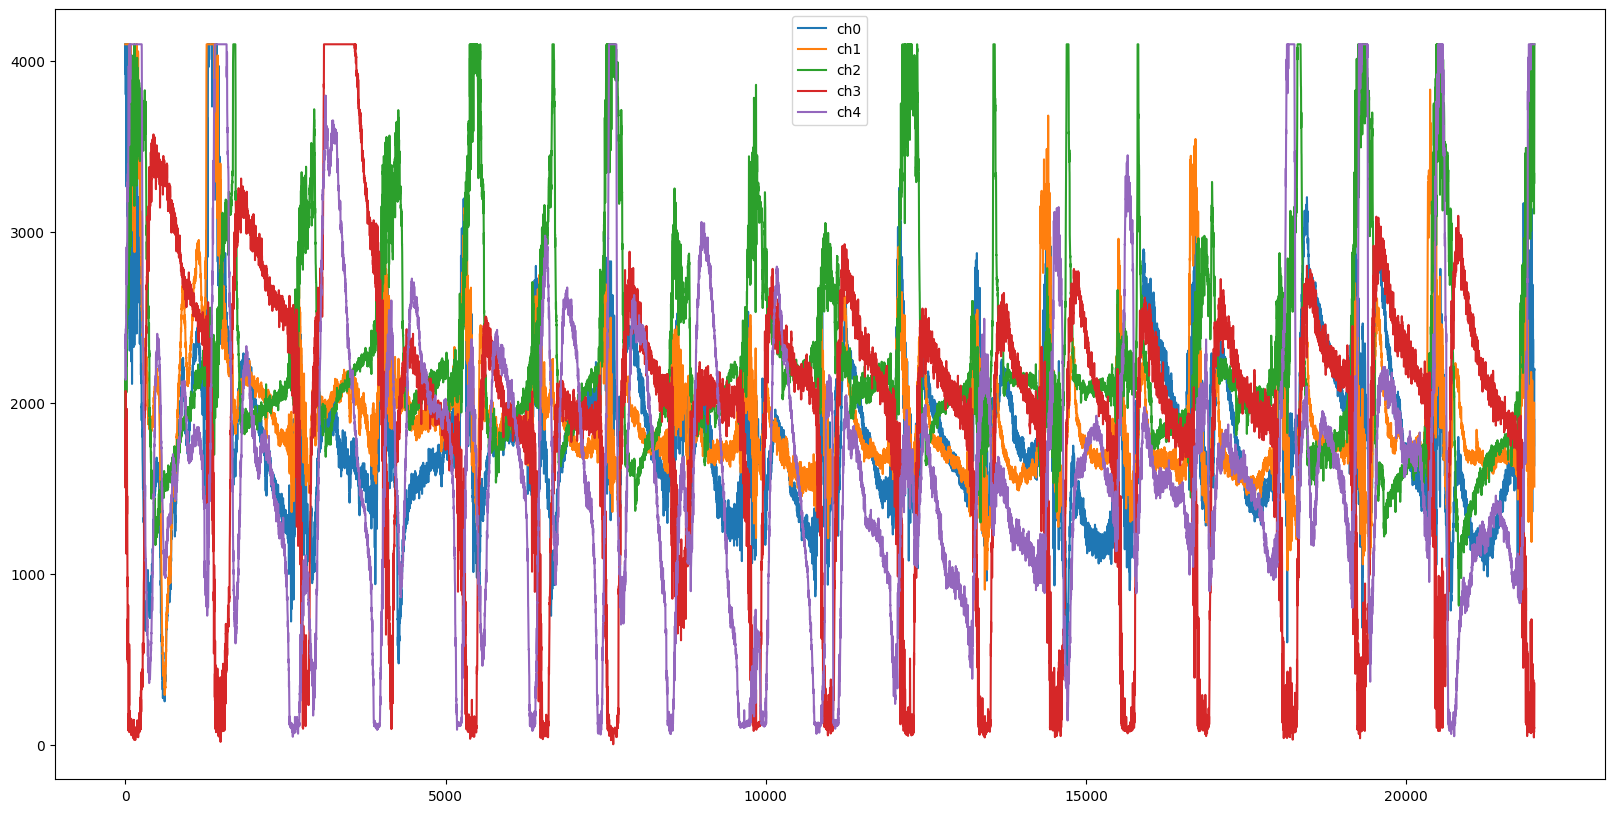

In [170]:
# given 6 columns, where the first column is the time, and the rest are the 5 channels, plot
# the data for each channel

# read the csv file
with open(csv_file_path, 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

data = np.array(data)
data = data[8000:30000]

# convert the data to ints
data = data.astype(int)

# plot the data
plt.figure(figsize=(20,10))
plt.plot(data[:,1], label='ch0')
plt.plot(data[:,2], label='ch1')
plt.plot(data[:,3], label='ch2')
plt.plot(data[:,4], label='ch3')
plt.plot(data[:,5], label='ch4')
plt.legend()
plt.show()


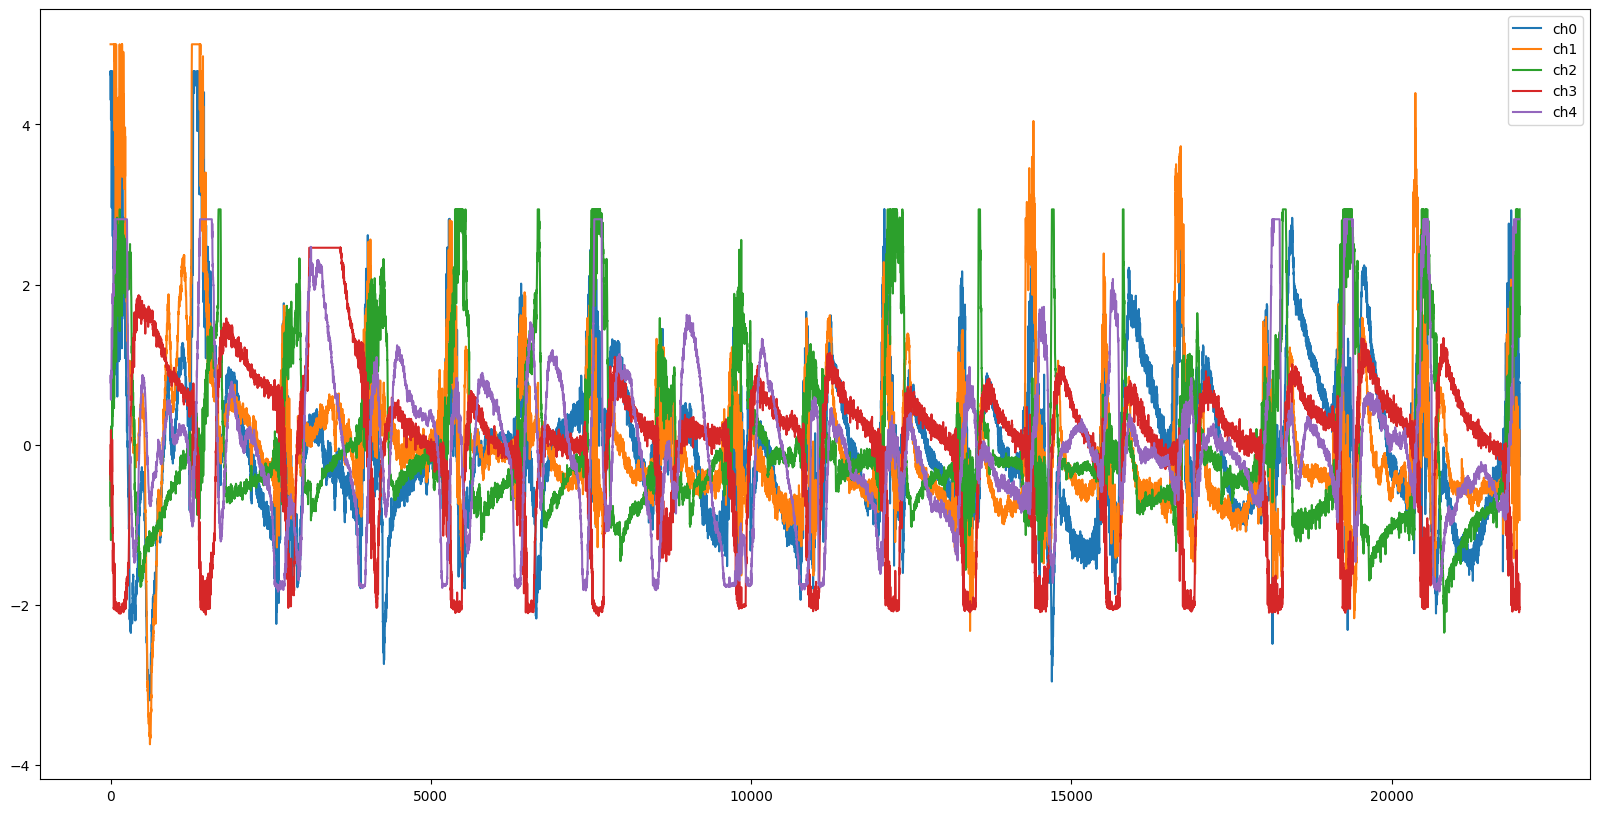

In [171]:
# read the csv file
with open(csv_file_path, 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

data = np.array(data)
data = data[8000:30000]

# convert the data to ints
data = data.astype(int)

# center and normalize the data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# plot the data
plt.figure(figsize=(20,10))
plt.plot(data[:,1], label='ch0')
plt.plot(data[:,2], label='ch1')
plt.plot(data[:,3], label='ch2')
plt.plot(data[:,4], label='ch3')
plt.plot(data[:,5], label='ch4')
plt.legend()
plt.show()

In [172]:
df = pd.read_csv(csv_file_path)
# remove first column
df = df.iloc[:, 1:]
df.head()

,ch0,ch1,ch2,ch3,ch4
0,37,4095,4095,4095,4095
1,31,4095,4095,4095,4095
2,114,4095,4095,4095,4095
3,34,4095,4095,4095,4095
4,34,4095,4095,4095,4095


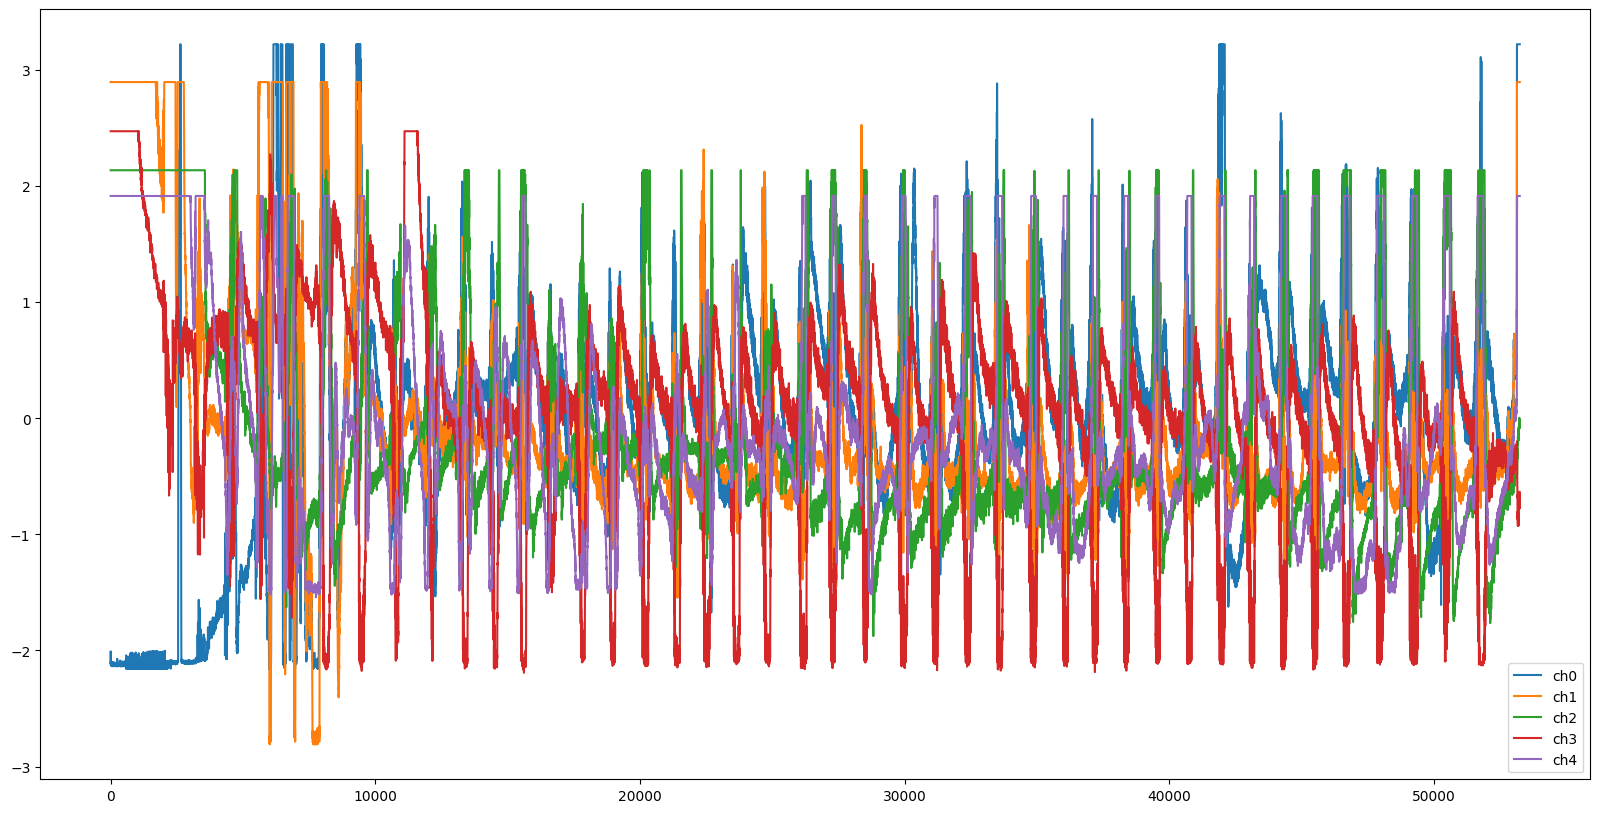

In [163]:
data = df.values

# center and normalize the data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# plot the data
plt.figure(figsize=(20,10))
plt.plot(data[:,0], label='ch0')
plt.plot(data[:,1], label='ch1')
plt.plot(data[:,2], label='ch2')
plt.plot(data[:,3], label='ch3')
plt.plot(data[:,4], label='ch4')
plt.legend()
plt.show() 

In [164]:
data = data.T

# run notch filter at 30, 60, 90, and 120 Hz
# convert to floats
data = data.astype(float)
#data = mne.filter.notch_filter(data, Fs=200, freqs=[30, 60, 90], verbose=True)

%gui qt5
mne.set_config('MNE_BROWSER_BACKEND', 'qt')

ch_names = [f'Channel {i + 1}' for i in range(data.shape[0])]
sfreq = 200  # Replace with your actual sampling frequency
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(data, info)
raw.plot(show_scrollbars=True, block=False, scalings="auto")

Creating RawArray with float64 data, n_channels=5, n_times=53248
    Range : 0 ... 53247 =      0.000 ...   266.235 secs
Ready.
Using pyopengl with version 3.1.7


Channels marked as bad:
none


Effective window size : 10.240 (s)


/var/folders/1r/3s253hw50_z29rw89v5v3n7m0000gn/T/ipykernel_23530/1932270572.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/inga/Desktop/Neurowrist/neurowrist-interfacing/venv/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


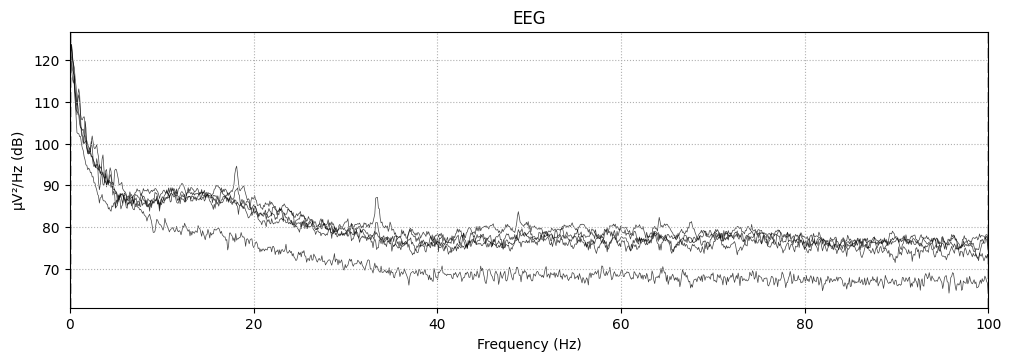

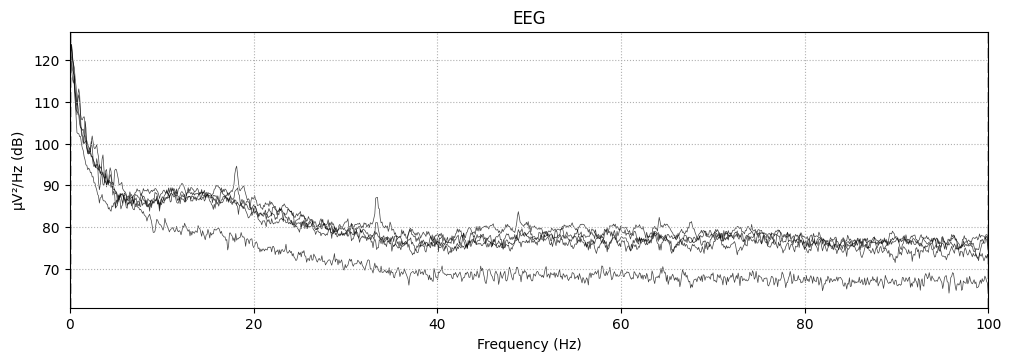

In [151]:
# do frequency analysis
raw.compute_psd().plot()

In [128]:
interactive_annot = raw.annotations
np.save(f"../../data/{task_type}/{session_id}/{task_id}_annotations.npy", interactive_annot)

In [155]:
# retrieve the annotations
annotations_path = f"../../data/{task_type}/{session_id}/{task_id}_annotations.npy"
annotations = np.load(annotations_path, allow_pickle=True)

# print the annotations
print("Example annotations:")
print(annotations[:5])

Example annotations:
[OrderedDict([('onset', 39.14443428351845), ('duration', 2.699150184339267), ('description', 'fist'), ('orig_time', None)])
 OrderedDict([('onset', 45.915762465551026), ('duration', 2.789725693880854), ('description', 'fist'), ('orig_time', None)])
 OrderedDict([('onset', 49.53811431703875), ('duration', 2.3351498553690035), ('description', 'stationary'), ('orig_time', None)])
 OrderedDict([('onset', 52.51132411010551), ('duration', 2.2437252004254873), ('description', 'fist'), ('orig_time', None)])
 OrderedDict([('onset', 56.18975329899894), ('duration', 2.3351498553690035), ('description', 'stationary'), ('orig_time', None)])]


In [278]:
import scipy.stats as stats

class DataBuilder:
    def __init__(self, window_size=2, sfreq=200):
        self.window_size = window_size
        self.sfreq = sfreq

    def load_data(self, data_path, annotations_path):
        df = pd.read_csv(data_path)
        annotations = np.load(annotations_path, allow_pickle=True)
        return df, annotations

    def preprocess_data(self, df):
        # drop the millis column
        df = df.iloc[:, 1:]

        data = df.values
        print("Printing some stats!\n====================")
        print("Number of samples:", len(data))
        print("Number of channels:", len(data[0]))
        print("Sampling frequency:", self.sfreq, "Hz")
        total_sec = len(data[:,0])/ self.sfreq
        print("Total recording duration:", total_sec, "seconds\n")

        return data
        
    def get_window_segment(self, data, onset, duration, sfreq):
        """Get a segment of the data from the onset to the onset + duration."""
        # data has shape samples x channels
        start = int(onset * sfreq)
        end = int((onset + duration) * sfreq)
        return data[start:end, :]

    def create_windows(self, data, annotations):
        print("Number of annotations:", len(annotations))
        windows = []

        for annot in annotations:
            onset = annot['onset']
            duration = annot['duration']
            window = self.get_window_segment(data, onset, duration, self.sfreq)
            windows.append(window)

        return windows
    
    def create_feature_vector(self, window):
        # window has shape samples x channels
        features = []
        for channel in window.T:
            mean = np.mean(channel)
            std = np.std(channel)
            kurtosis = stats.kurtosis(channel)
            skew = stats.skew(channel)
            features.append(mean)
            features.append(std)
            features.append(kurtosis)
            features.append(skew)
        return features

    def create_feature_matrix(self, windows):
        # windows has shape windows x samples x channels
        feature_matrix = []
        for window in windows:
            feature_vector = self.create_feature_vector(window)
            feature_matrix.append(feature_vector)
        return feature_matrix
    
    def get_labels(self, annotations):
        labels = []
        for annot in annotations:
            label = annot['description']
            labels.append(label)
        return labels

    def build_data(self, data_path, annotations_path):
        # Load data
        df, annotations = self.load_data(data_path, annotations_path)

        # Preprocess data
        processed_data = self.preprocess_data(df)

        # Create windows
        windows = self.create_windows(processed_data, annotations)

        # Create feature matrix
        X = self.create_feature_matrix(windows)

        # Get labels
        y = self.get_labels(annotations)

        return X, y

In [279]:

data_builder = DataBuilder(window_size=2)
data_path = csv_file_path
annotations_path = f"../../data/{task_type}/{session_id}/{task_id}_annotations.npy"

X, y = data_builder.build_data(data_path, annotations_path)

Printing some stats!
Number of samples: 53248
Number of channels: 5
Sampling frequency: 200 Hz
Total recording duration: 266.24 seconds

Number of annotations: 73


In [291]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# linear classifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [292]:
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

        fist       1.00      1.00      1.00        15
  stationary       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

